# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
sharedGFolderPath = "/content/gdrive/My Drive/TUM/Guided Research/"

# Import Libraries

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd
from sklearn import metrics

import scipy
import scipy.cluster.hierarchy as sch

import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [0]:
dataset_path = sharedGFolderPath + 'data/'
out_path = sharedGFolderPath + 'data/similarity_matrices/'

In [0]:
df = pd.read_csv(dataset_path + "train/dataframePerceptionUncertainty_SingleLabel.csv")
df['Entity_Sentiment'] = df['Coarse_Entity'] + '-' + df['Sentiment']
df.head()

,Sentence,Triplet,Coarse_Entity,Fine_Entity,Coarse_Attribute,Sentiment,Coarse_Attribute_PU,Entity_Sentiment
0,Cookifi is one of the leading Organic caterers...,organic-trustworthy sources-0,organic,organic companies,trustworthy sources,0,0.584687,organic-0
1,"With over a 100 organic dishes, and customizab...",organic-experienced quality-p,organic,organic companies,experienced quality,p,0.667373,organic-p
2,As of now they have 3 full fledged Organic Men...,organic-trustworthy sources-0,organic,organic companies,trustworthy sources,0,0.605438,organic-0
3,Organic Menus From Cookifi,organic-general-0,organic,organic companies,general,0,0.674021,organic-0
4,Organic egg production is the production of eg...,organic-environment-0,organic,organic farmers,environment,0,0.941320,organic-0


# Plot Similarity Matrix

In [0]:
def plot_similarity(similarities, col_label, short_labels, extended_labels = None, should_save = False):
    """ 
    Plot similarity matrix
    Parameters
    ----------
    similarities: list of list of float
        similarities of the different classes where each list indicates a new row in the matrix
    col_label: str
        one of the following: Coarse_Entity, Fine_Entity, Triplet
    short_labels: list of str
        contains all possible labels for <col_label>
    extended_labels: key value object
        full labels of the class names from <label>
    should_save: boolean
        whether the figure and similarity scores should be saved
    """

    labels = []
    if extended_labels:
        for sl in short_labels:
            labels.append(sl + ' (' + extended_labels[sl]+')') 
    else:
        labels = short_labels

    plt.figure(figsize=(10,10))
    g = sns.heatmap(similarities, annot=True, square=True, cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=90)
    g.set_yticklabels(labels, rotation=45)
    g.set_title("Semantic similarity of \n "+ col_label + " for the organic dataset", pad=50, fontsize=20)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    if should_save:
        heatmap = out_path + col_label + "_Similarity_Matrix.pdf"
        plt.savefig(heatmap, bbox_inches = "tight")

        pd.DataFrame(similarities, columns=labels, index=labels).to_csv(out_path + col_label + "_Similarity_Scores.csv")

# Calculate Similarity Matrix

In [0]:
def get_label_sim(embed, corpus, col_label, labels, col_text, metric='inner'):
    """
    Create similarity matrix for a given label
    
    Parameters
    ----------
    embed: USE model
    corpus: dataframe
    col_label: str
        one of the following: Entity, Entity_general, Attribute, Attribute_general, Aspect_general
    labels: list of str
        contains all possible labels for <col_label>
    col_text: str
        column of the dataframe that contains the sentence
    metric: str
        which metric to use calculate similarity between embeddings
    """
    
    similarities = []
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
        similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
        for i, lab1 in enumerate(labels):
            tmp_similarities = []
            sentences1 = corpus[corpus[col_label] == lab1][col_text].tolist()
            if len(sentences1) > 0:
                similarity_message_encodings = embed(similarity_input_placeholder)
                sentence_embeddings1 = session.run(similarity_message_encodings, feed_dict={similarity_input_placeholder: sentences1})
            for j, lab2 in enumerate(labels):
                if i > j:
                    tmp_similarities.append(similarities[j][i])
                else:    
                    sentences2 = corpus[corpus[col_label] == lab2][col_text].tolist()
                    if len(sentences1) == 0 or len(sentences2) == 0:
                        tmp_similarities.append(0.0)
                    else:
                        # this creates a list of sentence embeddings produced by sentencesI, I = [1,2]
                        sentence_embeddings2 = session.run(similarity_message_encodings, feed_dict={similarity_input_placeholder: sentences2})
                        
                        if metric == 'inner':
                            in_cat_similarities = np.inner(sentence_embeddings1, sentence_embeddings2)
                        elif metric == 'cosine':
                            in_cat_similarities = metrics.pairwise.cosine_similarity(sentence_embeddings1, sentence_embeddings2)
                        elif metric == 'mse':
                            print(sentence_embeddings1.shape, sentence_embeddings2.shape)
                            in_cat_similarities = [[metrics.mean_squared_error(embed1,embed2) for embed2 in sentence_embeddings2] for embed1 in sentence_embeddings1]
                            print(len(in_cat_similarities), len(in_cat_similarities[0]))
                        
                        # similarity of two classes = average of the similarities of all sentences from the two classes 
                        if lab1 == lab2:
                            total = np.sum(np.triu(np.ones_like(in_cat_similarities)))
                            total_sum = np.sum(np.triu(in_cat_similarities))
                            tmp_similarities.append(total_sum/total)
                        else:
                            tmp_similarities.append(np.mean(in_cat_similarities))

            similarities.append(np.asarray(tmp_similarities))
        
        session.close()
    return similarities

# Main

In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [0]:
#load universal sentence encoder
embed = hub.Module(module_url)

In [0]:
all_labels = {'Coarse_Entity': ['organic', 'conventional', 'GMO'], 'Coarse_Attribute': ['general', 'price', 'experienced quality', 'safety and healthiness', 'trustworthy sources', 'environment'],
              'Entity_Sentiment': ['organic-0', 'organic-p', 'organic-n', 'conventional-0', 'conventional-p', 'conventional-n', 'GMO-0', 'GMO-p', 'GMO-n'],
              'Triplet': [ent+'-'+att+'-'+sent for ent in ['organic', 'conventional', 'GMO'] for att in ['general', 'price', 'experienced quality', 'safety and healthiness', 'trustworthy sources',
                                                                                                         'environment'] for sent in ['0', 'p', 'n']],
              'Fine_Entity': ['organic general', 'organic products', 'organic farmers', 'organic companies', 'conventional general', 'conventional products', 'conventional farming',
                              'conventional companies','GMOs genetic engineering general']}

In [0]:
col_label = "Coarse_Attribute"
labels = all_labels[col_label]
similarities = get_label_sim(embed, df, col_label, labels, "Sentence", metric='mse')

In [0]:
similarities

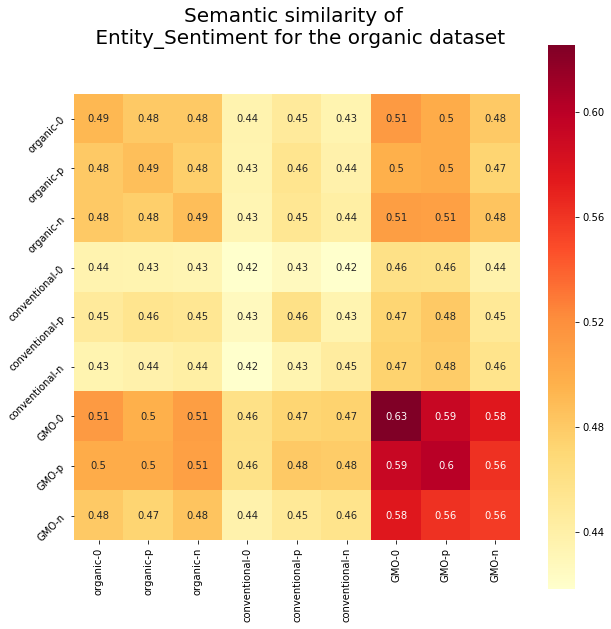

In [0]:
plot_similarity(similarities, col_label, labels, should_save=True)

# Load Saved Scores (For testing)

In [6]:
load_scores = pd.read_csv(out_path + 'Coarse_Attribute_Similarity_Scores.csv', index_col=0)
load_scores.head(10)

,general,price,experienced quality,safety and healthiness,trustworthy sources,environment
general,0.460989,0.448774,0.469309,0.474955,0.456538,0.472774
price,0.448774,0.518912,0.465965,0.453787,0.448242,0.466503
experienced quality,0.469309,0.465965,0.537229,0.507394,0.462900,0.477782
safety and healthiness,0.474955,0.453787,0.507394,0.544601,0.462519,0.500364
trustworthy sources,0.456538,0.448242,0.462900,0.462519,0.477852,0.445650
environment,0.472774,0.466503,0.477782,0.500364,0.445650,0.545405


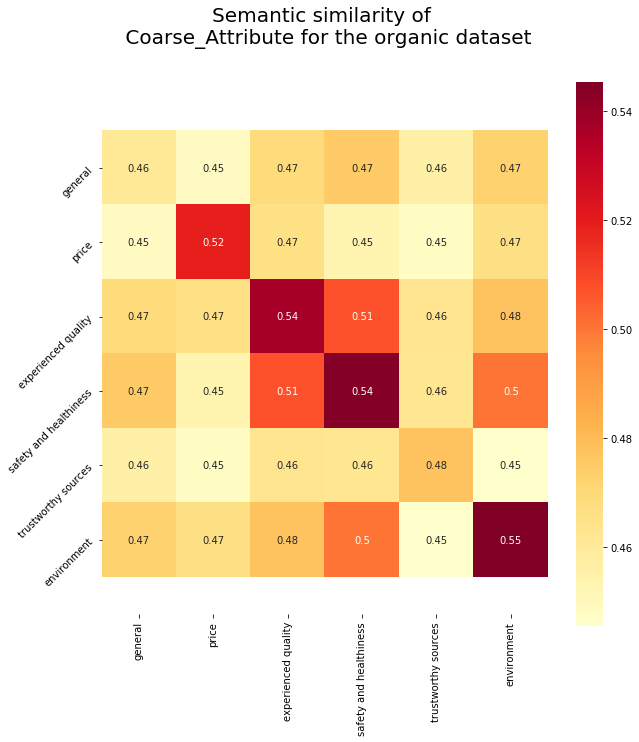

In [11]:
col_label = "Coarse_Attribute"
labels = all_labels[col_label]
plot_similarity(load_scores.to_numpy(), col_label, labels, should_save=False)